# Different Solutions for 1-Dimensional-1-Phase Problem

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1-5ztISn_pEuNjBWLEckyimFk1pDJf9wc/view?usp=drive_link&target=_blank)

*Author: Zakariya Abugrin | Date: May 2025*

In [1]:
# Colab only:
try:
    # Install reservoirflow in Colab
    import os
    import google.colab
    !pip install reservoirflow
    # Restart session after installation
    os.kill(os.getpid(), 9)
    print("Session was restarted.")
    print("Now you can run to the following cells.")
except ImportError:
    pass

## Introduction

The solution for a simple 1-dimensional-1-phase (1D1P) problem is available in all solutions which includes: `analytical`, `numerical`, `neurical`. In tutorial, we will see how we can build all solutions and compare them together. 

## Prerequisites:
Before you can follow this tutorial, you need to understand the following tutorials:
1. [Understand scalers Module](/user_guide/tutorials/tutorial_understand_scalers_module.html).
2. [Understand Compiling](/user_guide/tutorials/tutorial_understand_compiling.html).

## Import `reservoirflow`

We start with importing `reservoirflow` as `rf`. The abbreviation `rf` refers to `reservoirflow` where all modules under this library can be accessed. `rf` is also used throughout the [API](/api/API.html) documentation. We recommend our users to stick with this convention.

In [2]:
import reservoirflow as rf
import numpy as np

print(rf.__version__)

0.1.0b3


## Build a model

A reservoir simulation model requires two objects: `Grid` and `Fluid`. The function below `create_model()` starts by creating these objects which are used to initiate a `Model` object using [`BlackOil`](/api/reservoirflow.models.BlackOil.html) class. 

In [3]:
def create_model(nx=101, n_w=2, comp=False, dtype="double", verbose=False):
    # Compressibility:
    if comp:
        g_comp = 1 * 10**-6
        f_comp = 1 * 10**-5
    else:
        g_comp = None
        f_comp = None
    # Grid:
    grid = rf.grids.RegularCartesian(
        nx=nx,
        ny=1,
        nz=1,
        dx=300,
        dy=350,
        dz=40,
        phi=0.27,
        kx=270,
        comp=g_comp,
        dtype=dtype,
    )
    # Fluid:
    fluid = rf.fluids.SinglePhase(
        mu=0.5,
        B=1,
        comp=f_comp,
        dtype=dtype,
    )
    # Model:
    model = rf.models.BlackOil(grid, fluid, pi=4000, dtype=dtype, dt=1, verbose=verbose,)
    # Wells:
    if n_w > 0:
        well_ids = np.cumsum([nx // (n_w + 1) for i in range(n_w)])
        print("Wells_ids:", well_ids)
        for well_id in well_ids:
            # model.set_well(id=well_id, q=-600, s=1.5, r=3.5)
            model.set_well(id=well_id, pwf=1000, s=1.5, r=3.5)
        # Boundaries:
        model.set_boundaries({
            0: ("pressure", 4000),  # left boundary
            nx + 1: ("pressure", 4000), # right boundary
            })
    else:
        # Boundaries:
        model.set_boundaries({
            0: ("pressure", 1000), # left boundary
            nx + 1: ("pressure", 4000), # right boundary
            })

    return model

Lets create the model:

In [4]:
model = create_model(n_w=0, comp=True, verbose=False)
print("Current solutions:", model.solutions)

Current solutions: {}


```{note}
When a model is created, compiled solutions are made available under the dictionary ``model.solutions`` after executed (i.e. ``model.run()``). The model always switches to the latest compiled solution. To change to previous solutions, ``model.set_solution()`` can be used with the solution names same as shown in the dictionary ``model.solutions``.
```

## Define Scalers

Scaling is an important feature in `reservoirflow` and has many applications. Most important: to allow bringing different solutions to the same domains.

Before we compile the model to different solutions, we can show and setup the scaling for different features as shown in [Understand scalers Module](/user_guide/tutorials/tutorial_understand_scalers_module.html). Scalers are defined by default and can be accessed using `model.scalers_dict` as following: 

In [5]:
model.scalers_dict  # model.get_scalers()

{'time': ['MinMax', (0, 1)],
 'space': ['MinMax', (-1, 1)],
 'pressure': ['MinMax', (-1, 1)],
 'rate': [None, None]}

We can use `model.set_scalers()` to change the scaling for one or several variables as following:

In [6]:
model.set_scalers(
    {
        "time": ("MinMax", (0, 1000)),
        # "space": ["LogMinMax", (-1, 1)],
        # "pressure": ["LogMinMax", (-1, 1)],
    },
)
model.scalers_dict

{'time': ['MinMax', (0, 1000)],
 'space': ['MinMax', (-1, 1)],
 'pressure': ['MinMax', (-1, 1)],
 'rate': [None, None]}

```{note}
To exclude variables from scaling, `None` value is used which is the case for `rate` in the example above. 
```

## Compile the model

Before you can run the model, you need to compile a solution for it. By compiling a solution, you actually decide the solution you want to use for your model. Interestingly, `reservoirflow` provides multiple solutions for the same model based on your configuration, see [Understand Compiling](/user_guide/tutorials/tutorial_understand_compiling.html).

After the model is compiled, method `model.run()` will be available. Solutions might have different configurations available under this method. However, we can define common configuration for all solutions as a dictionary:


In [7]:
common_run_config = dict(
    nsteps=100,
    threading=True,
    vectorize=True,
)

```{tip}
In common run configuration, you would include parameters that are shared by all models. For example, `nsteps`.
```

### Numerical Solution

We can compile the model using the numerical solution based on Finite-Difference-Method (FDM). This solution can be obtained as following:

In [8]:
model.compile(
    stype="numerical", # solution typle
    method="FDM", # solution method
    sparse=True, # sparse matrix
    name=f"Numerical (Nx=101)", # name of the solution
)

[info] FDM was assigned as model.solution.


After the model is compiled we can use `help` function to know about the required arguments for the selected solution: 

In [9]:
help(model.run)

Help on method run in module reservoirflow.solutions.numerical.fdm:

run(nsteps=10, threading=True, vectorize=True, check_MB=True, print_arrays=False, isolver=None) method of reservoirflow.solutions.numerical.fdm.FDM instance
    Perform a simulation run for nsteps.
    
    Parameters
    ----------
    nsteps : int, optional
        number of simulation steps to run, by default 10.
    threading : bool, optional
        use multiple threads for concurrence workers. The maximum
        number of threads are set to the half number of cells.
    vectorize : bool, optional
        use vectorized matrices instead of symbolic matrices.
        This is recommended for better performance.
    check_MB : bool, optional
        check material balance error after each step.
    print_arrays : bool, optional
        print the arrays of matrices A and d after each step.
    isolver : str, optional
        iterative solver for sparse matrices. Available solvers are
        ["bicg", "bicgstab", "cg

Now that the solution was compiled without issues, the model can be run for the number of `nsteps`: 

In [10]:
model.run(**common_run_config)

[info] Simulation run started: 100 timesteps.


[step]: 100%|██████████| 100/100 [00:00<00:00, 380.58steps/s]

[info] Simulation run of 100 steps finished in 0.28 seconds.
[info] Material Balance Error: 1.2148060335448463e-12.


Results can be shown for the complied solutions as following: 

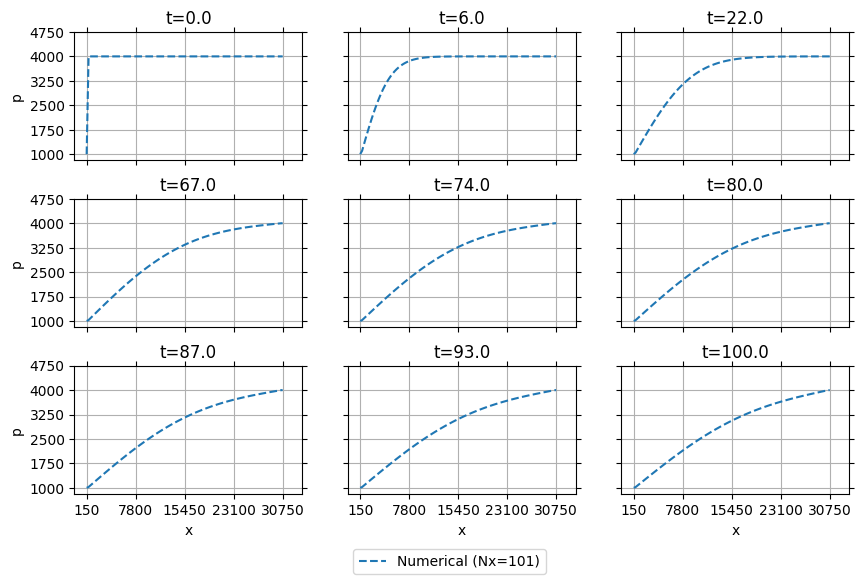

In [11]:
model.plot(boundary=True, scale=False)

```{note}
Values are shown with scaling `scaling=False` and boundaries `boundaries=True`.
```

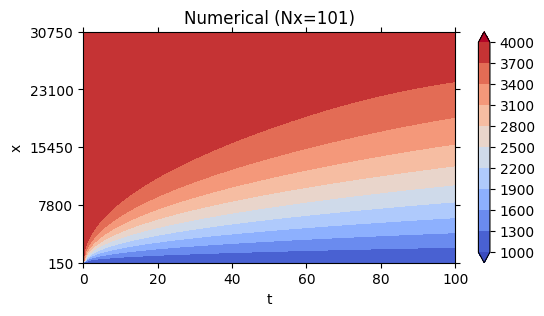

In [12]:
model.plot(type="contour", boundary=True, scale=False)

### Analytical Solution

This is a single phase fluid flow in 1D with a defined boundaries. The analytical solution of this problem is characterized as homogeneous PDE with nonhomogeneous BC and can be obtained as following:

[](reference) <!-- (ch04_homogeneousPDE_nonhomogeneousBC_12) -->

$
u(x,t) = u_0 + \frac{u_L - u_0}{L}x +
\frac{2}{\pi} \, \sum_{n=1}^{\infty}
\biggr[(u_i - u_0)\frac{1}{n} + (u_L-u_i)\frac{(-1)^n}{n} \biggr ] \,
\sin(\frac{n \pi x}{L}) \, e^{-{\frac{n^2 \pi^2}{L^2}} \alpha t} 
\qquad \text{where} \quad n \in \mathbb{N}
$

The exact solution is approached as $N \to \infty$ (i.e. Lower N values give poor results).

This solution can be selected by compiling the model as following: 

In [13]:
N = 2  # Number of terms in the analytical solution
model.compile(
    stype="analytical", 
    method="1D1P", 
    sparse=True, 
    name=f'Analytical (N={N})',
)

[info] D1P1 was assigned as model.solution.


Now that the solution was compiled without issues, the model can be run for the number of `nsteps` and the provided `N`: 

In [14]:
model.run(**common_run_config | {"N": N, "clean": False})

[info] Simulation run started: 100 timesteps.


[step]: 100%|██████████| 2/2 [00:00<00:00, 997.69steps/s]

[info] Simulation run of 100 steps finished in 0.01 seconds.
[info] Material Balance Error: 0.49691631334143005.


Results can be shown for the complied solutions as following: 

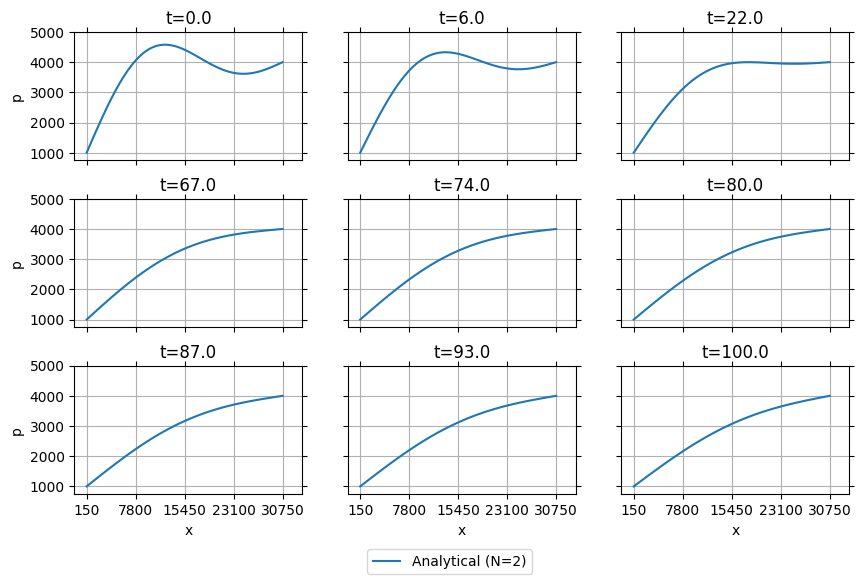

In [15]:
model.plot(boundary=True, scale=False)

```{note}
Values are shown without scaling `scaling=False` but with boundaries `boundaries=True`.
```

We can improve the analytical solution by using `N=200` and `clean=True` which will exclude values outside of the defined range. 

In [16]:
N = 2000  # Number of terms in the analytical solution
model.compile(
    stype="analytical",
    method="1D1P",
    sparse=True,
    name=f"Analytical (N={N})",
)

[info] D1P1 was assigned as model.solution.


In [17]:
common_run_config = dict(
    nsteps=100,
    vectorize=True,
    threading=True,
)
model.run(**common_run_config | {"N": N, "clean": False})

[info] Simulation run started: 100 timesteps.


[step]: 100%|██████████| 2000/2000 [00:00<00:00, 56348.17steps/s]


[info] Simulation run of 100 steps finished in 0.3 seconds.
[info] Material Balance Error: 0.49691474861462603.


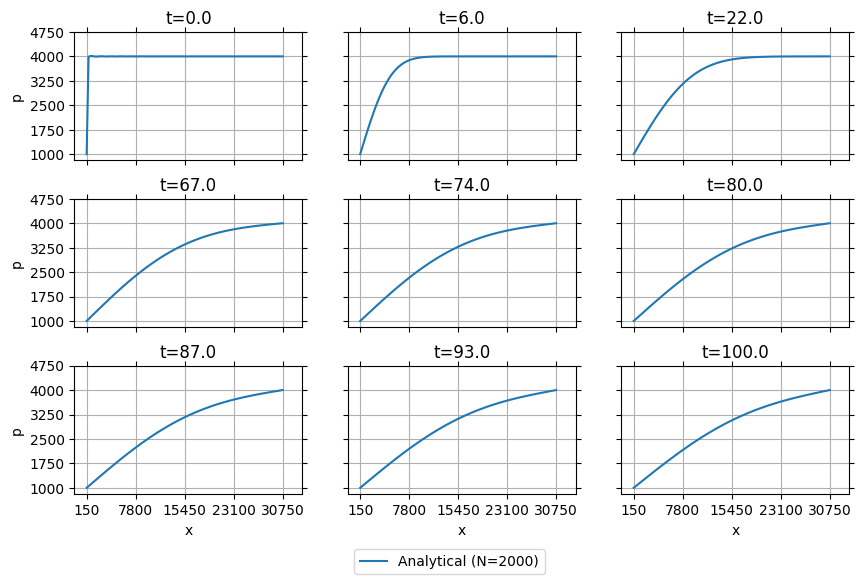

In [18]:
model.plot(boundary=True, scale=False)

```{note}
Values are shown with scaling `scaling=True` but with boundaries `boundaries=True`. Scaled values should match what we defined earlier in `model.set_scalers()` method.
```

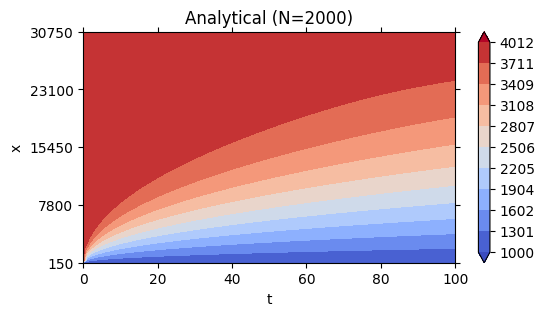

In [19]:
model.plot(type="contour", boundary=True, scale=False)

### Neurical Solution

Now, we see the interesting part of `reservoirflow` where solutions based on Physics-informed-Neural-Networks (PINNs) can also be obtained. We can compile this solutions as following: 

In [20]:
model.compile(
    stype="neurical",  # solution typle
    method="PINN",  # solution method
    sparse=True,  # sparse matrix
    name=f"Neurical (PINN)",  # name of the solution
)

[info] PINN was assigned as model.solution.


## Comparing Solutions

First, we check all available solution for the model using `model.print_solutions()` as follows:

In [21]:
model.print_solutions()

╭────┬─────────────────────┬────────────┬──────────┬──────────┬─────────┬──────────┬─────────┬───────────────┬───────────────╮
│    │ name                │ stype      │ method   │ sparse   │   tstep │   nsteps │   ctime │   tstep_error │   ctime_error │
├────┼─────────────────────┼────────────┼──────────┼──────────┼─────────┼──────────┼─────────┼───────────────┼───────────────┤
│  0 │ Numerical (Nx=101)  │ Numerical  │ FDM      │ True     │     100 │      101 │    0.28 │   1.21481e-12 │    0.01       │
│  1 │ Analytical (N=2)    │ Analytical │ D1P1     │ True     │     100 │      101 │    0.01 │   0.496916    │    0.00503084 │
│  2 │ Analytical (N=2000) │ Analytical │ D1P1     │ True     │     100 │      101 │    0.3  │   0.496915    │    0.00533607 │
│  3 │ Neurical (PINN)     │ Neurical   │ PINN     │ True     │       0 │        1 │    0    │   0           │    0          │
╰────┴─────────────────────┴────────────┴──────────┴──────────┴─────────┴──────────┴─────────┴───────────────┴─

Method `model.plot()` takes the last complied solution. You can use `model.set_solution(name)` to switch to another solution. Or use `model.plot(solution)` to explicitly define the solution name you want to plot. For example: 

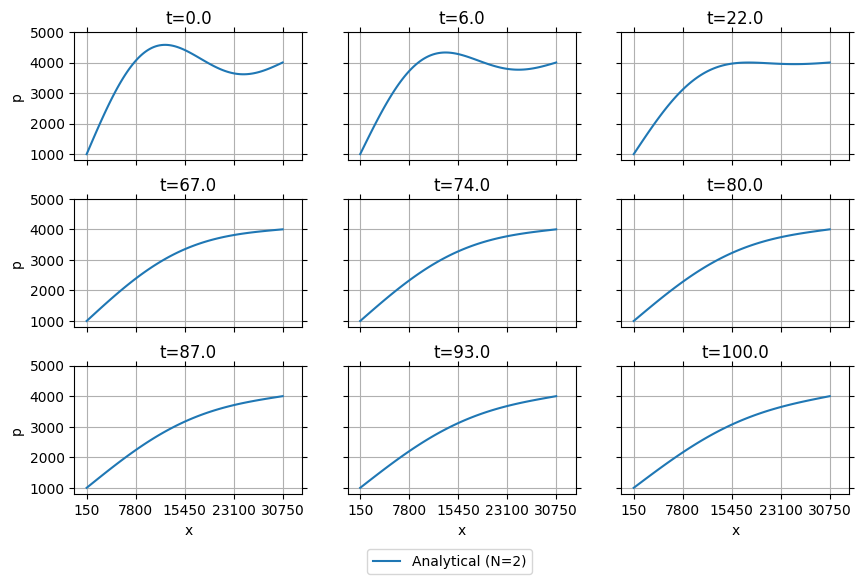

In [ ]:
model.plot(
    type="line",
    boundary=True,
    scale=False,
    solution="Analytical (N=2)",
)

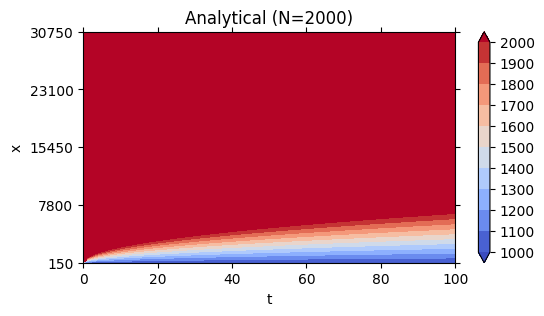

In [ ]:
model.plot(
    type="contour", 
    boundary=True, 
    scale=False,
    solution="Analytical (N=2000)",
    ylims=(1000, 4000),
)

Another feature is to plot `all` solutions together for comparison as follows: 

[info] Solution: Neurical (PINN) was ignored (no run was executed.)


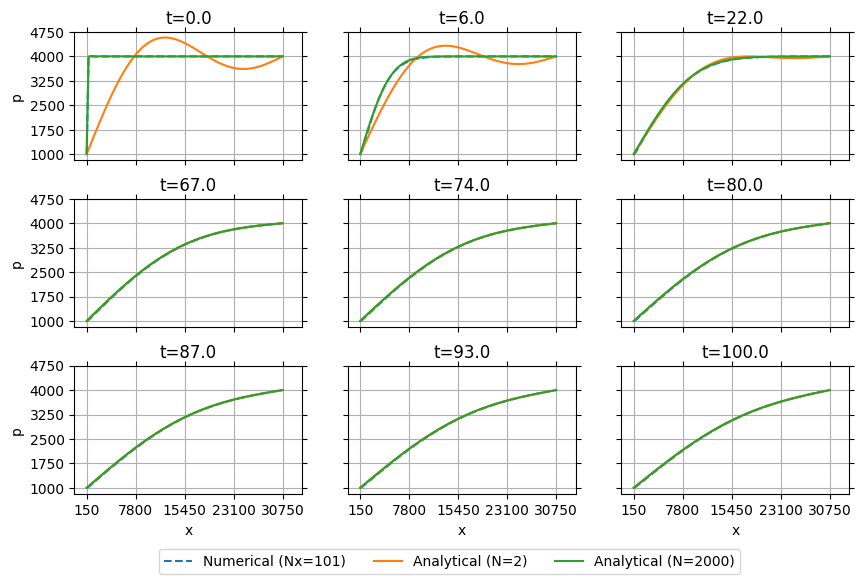

In [24]:
model.plot(solution="all", scale=False)  # or model.plot_solutions()

[info] Solution: Neurical (PINN) was ignored (no run was executed.)


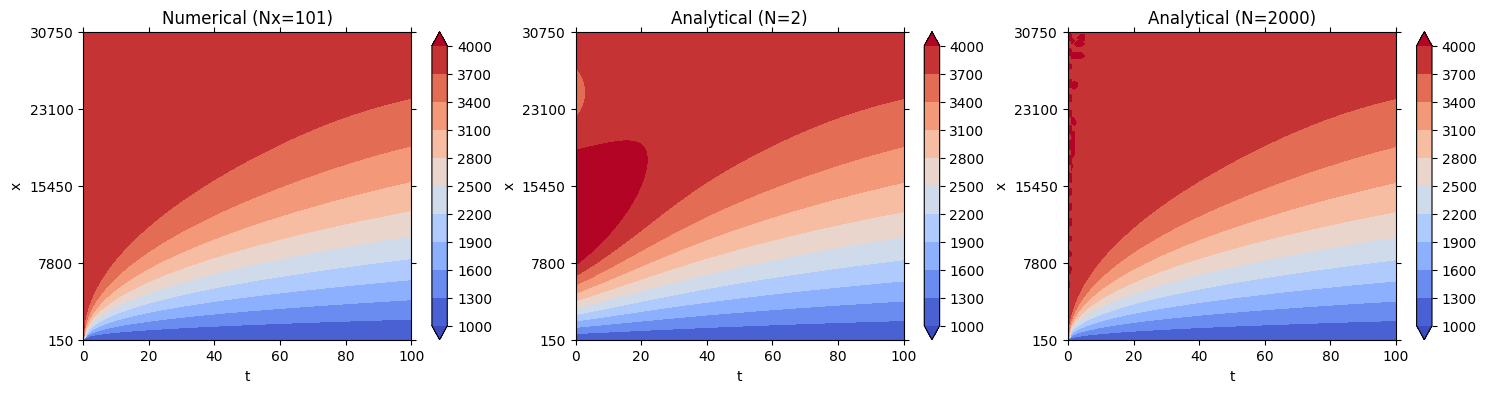

In [31]:
model.plot(
    type="contour",
    boundary=True,
    scale=False,
    solution="all",
    # ylims=(1000, 4000),
)

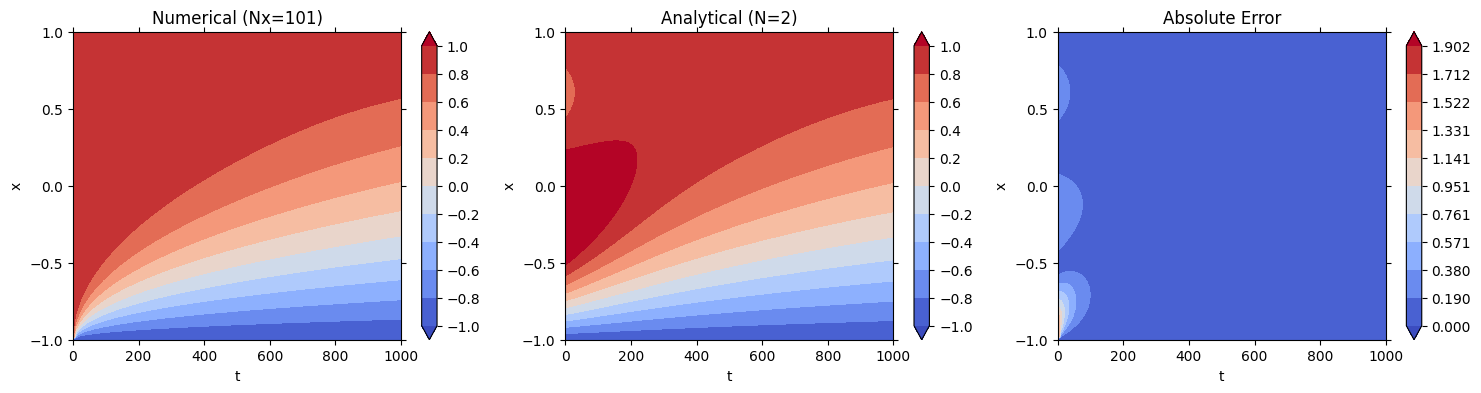

In [37]:
model.plot(
    type="contour",
    boundary=True,
    scale=True,
    solution=[
        "Numerical (Nx=101)",
        # "Analytical (N=2000)",
        "Analytical (N=2)",
    ],
    error=True,
    # ylims=(-1, 1),
)

```{include} /_static/comments_section.md
```